# SleepGuard – WESAD Stress Classification (KH6001CMD Coursework)

This notebook implements the full machine learning pipeline for the **SleepGuard** project using the **WESAD** dataset:

- Problem type: **Classification** (Stress vs No Stress)
- Dataset: **WESAD – Wearable Stress and Affect Detection**
- Programming language: **Python 3**
- Environment: Jupyter Notebook (VS Code / Anaconda)

The structure of this notebook is aligned with the KH6001CMD coursework requirements:

1. Problem description and dataset loading  
2. Data exploration and preprocessing  
3. Feature extraction from physiological signals  
4. Supervised learning models (Logistic Regression, Random Forest, MLP)  
5. Unsupervised learning for feature engineering (PCA)  
6. Hyperparameter tuning and performance analysis  
7. Model comparison and visualisation  
8. (Optional) Deep learning on raw time-series (1D CNN)  
9. Exporting results for the written report

## 1. Imports and Global Configuration

In this section we import all required Python libraries and configure global settings such as the data directory and random seed.

In [1]:
import os, pickle
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# quick plot formatting
plt.rcParams["figure.figsize"] = (7,4)
plt.rcParams["axes.grid"] = True

DATA_DIR = r"C:\Users\dell\Desktop\ML\WESAD"

# reproducibility (hopefully)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 2. Dataset Structure and Subject Listing

WESAD is organised by subject, where each subject has its own folder (e.g. `S2`, `S3`, …), and each folder contains a corresponding `.pkl` file (e.g. `S2.pkl`).

We start by listing all subject folders to confirm that the dataset is correctly structured.

In [2]:
subjects = sorted([d for d in os.listdir(DATA_DIR) if d.startswith("S")])
print("Detected subject folders:", subjects)

# Quick sanity check for one subject
example_subject = subjects[0]
example_path = os.path.join(DATA_DIR, example_subject, example_subject + ".pkl")
print("Example subject pickle file:", example_path, "exists:", os.path.exists(example_path))


Detected subject folders: ['S10', 'S11', 'S13', 'S14', 'S15', 'S16', 'S17', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9']
Example subject pickle file: C:\Users\dell\Desktop\ML\WESAD\S10\S10.pkl exists: True


## 3. Label Mapping and Feature Extraction

According to the WESAD documentation, labels are encoded as integers:

- `1` – Baseline (no stress)  
- `2` – Stress (TSST protocol)  
- `3` – Amusement (no stress)  
- `4`, `5` – Meditation / additional non-stress conditions  
- `0` – Transition/undefined  

For the SleepGuard project we map labels to a **binary classification** task:

- **No Stress (0)**: baseline, amusement, meditation → labels `{1, 3, 4, 5}`  
- **Stress (1)**: TSST segment → label `{2}`  
- Transitions (0) are ignored.

We then extract **window-level statistical features** from the wrist signals (Empatica E4):

- Blood Volume Pulse (BVP) – heart rate related  
- Electrodermal Activity (EDA) – skin conductance (electrolyte-based)  
- Skin Temperature (TEMP)  
- 3-axis Acceleration (ACC_x, ACC_y, ACC_z)

Signals are downsampled to **4 Hz**, segmented into **60-second windows** (240 samples) and summarised using mean, standard deviation, minimum, maximum and median.

In [4]:
def map_label(raw_label: int):
    """Map WESAD raw labels to binary stress labels.

    Returns:
        1 for stress, 0 for no-stress, None for transition/undefined.
    """
    if raw_label == 2:
        return 1  # Stress
    elif raw_label in [1, 3, 4, 5]:
        return 0  # No-stress
    else:
        return None  # ignore transitions / undefined


def process_subject_features(subject_folder: str, fs_target: int = 4, window_sec: int = 60):
    """Extract window-level statistical features from a single subject."""
    pkl_path = os.path.join(DATA_DIR, subject_folder, subject_folder + ".pkl")
    print(f"Processing features for {subject_folder}: {pkl_path}")

    with open(pkl_path, "rb") as f:
        data = pickle.load(f, encoding="latin1")

    wrist = data["signal"]["wrist"]
    labels_raw = data["label"].ravel()

    # Downsample to 4 Hz
    bvp = wrist["BVP"][::16]       # 64 Hz -> 4 Hz
    eda = wrist["EDA"]            # already 4 Hz
    temp = wrist["TEMP"]          # already 4 Hz
    acc = wrist["ACC"][::8, :]    # 32 Hz -> 4 Hz (Nx3)
    labels_ds = labels_raw[::175] # 700 Hz -> 4 Hz

    # Trim all to same length
    L = min(len(bvp), len(eda), len(temp), len(acc), len(labels_ds))
    bvp, eda, temp, acc, labels_ds = (
        bvp[:L], eda[:L], temp[:L], acc[:L], labels_ds[:L]
    )

    fs = fs_target
    window_size = fs * window_sec

    X_windows = []
    y_windows = []

    def stats(arr):
        arr = np.asarray(arr)
        return [
            float(np.mean(arr)),
            float(np.std(arr)),
            float(np.min(arr)),
            float(np.max(arr)),
            float(np.median(arr)),
        ]

    for start in range(0, L - window_size, window_size):
        end = start + window_size

        labels_window = labels_ds[start:end]
        lab_raw, _ = Counter(labels_window).most_common(1)[0]
        lab = map_label(lab_raw)
        if lab is None:
            continue

        w_bvp = bvp[start:end]
        w_eda = eda[start:end]
        w_temp = temp[start:end]
        w_acc = acc[start:end, :]  # (window_size, 3)

        feat = []
        feat += stats(w_bvp)
        feat += stats(w_eda)
        feat += stats(w_temp)
        feat += stats(w_acc[:, 0])  # acc_x
        feat += stats(w_acc[:, 1])  # acc_y
        feat += stats(w_acc[:, 2])  # acc_z

        X_windows.append(feat)
        y_windows.append(lab)

    X_feat = np.array(X_windows)
    y = np.array(y_windows)
    return X_feat, y


### 3.1 Build the Full Feature Dataset

We now loop over all subjects, extract window-level features and concatenate them into a single dataset for model training and evaluation.

In [5]:
X_list = []
y_list = []

for subj in subjects:
    X_subj, y_subj = process_subject_features(subj)
    print(f"{subj}: {X_subj.shape[0]} windows, stress ratio = {y_subj.mean():.3f}" if X_subj.shape[0] > 0 else f"{subj}: no windows")
    if X_subj.shape[0] > 0:
        X_list.append(X_subj)
        y_list.append(y_subj)

X = np.vstack(X_list)
y = np.hstack(y_list)

print("\nFinal feature matrix shape:", X.shape)
print("Class distribution:", Counter(y))

channels = ["bvp", "eda", "temp", "acc_x", "acc_y", "acc_z"]
stat_names = ["mean", "std", "min", "max", "median"]

feature_names = [f"{ch}_{st}" for ch in channels for st in stat_names]

df = pd.DataFrame(X, columns=feature_names)
df["label"] = y
df.head()


Processing features for S10: C:\Users\dell\Desktop\ML\WESAD\S10\S10.pkl
S10: 52 windows, stress ratio = 0.231
Processing features for S11: C:\Users\dell\Desktop\ML\WESAD\S11\S11.pkl
S11: 52 windows, stress ratio = 0.212
Processing features for S13: C:\Users\dell\Desktop\ML\WESAD\S13\S13.pkl
S13: 52 windows, stress ratio = 0.212
Processing features for S14: C:\Users\dell\Desktop\ML\WESAD\S14\S14.pkl
S14: 51 windows, stress ratio = 0.216
Processing features for S15: C:\Users\dell\Desktop\ML\WESAD\S15\S15.pkl
S15: 50 windows, stress ratio = 0.220
Processing features for S16: C:\Users\dell\Desktop\ML\WESAD\S16\S16.pkl
S16: 49 windows, stress ratio = 0.224
Processing features for S17: C:\Users\dell\Desktop\ML\WESAD\S17\S17.pkl
S17: 50 windows, stress ratio = 0.240
Processing features for S2: C:\Users\dell\Desktop\ML\WESAD\S2\S2.pkl
S2: 48 windows, stress ratio = 0.208
Processing features for S3: C:\Users\dell\Desktop\ML\WESAD\S3\S3.pkl
S3: 50 windows, stress ratio = 0.220
Processing feature

,bvp_mean,bvp_std,bvp_min,bvp_max,bvp_median,eda_mean,eda_std,eda_min,eda_max,eda_median,...,acc_y_std,acc_y_min,acc_y_max,acc_y_median,acc_z_mean,acc_z_std,acc_z_min,acc_z_max,acc_z_median,label
0,-0.483250,49.952025,-209.62,218.19,3.160,0.383081,0.013742,0.368402,0.431082,0.378636,...,1.816571,-5.0,16.0,3.0,52.941667,12.073936,-31.0,62.0,55.0,0
1,1.643583,53.960096,-223.22,383.93,3.145,0.378881,0.003904,0.369681,0.401661,0.378636,...,1.591099,-2.0,16.0,3.0,51.012500,10.051733,-33.0,63.0,54.0,0
2,0.171750,26.692965,-156.11,218.67,1.625,0.381173,0.007077,0.369681,0.417011,0.378636,...,1.094652,0.0,7.0,3.0,49.629167,1.143816,47.0,55.0,49.0,0
3,0.758083,32.409115,-212.85,279.88,1.685,0.390564,0.005377,0.376077,0.408057,0.390148,...,1.137363,2.0,16.0,6.0,51.679167,6.884855,-30.0,61.0,52.0,0
4,-0.102417,51.823201,-260.27,286.20,1.070,0.380053,0.007115,0.364565,0.447711,0.379915,...,1.641894,0.0,14.0,5.0,51.050000,10.790698,-26.0,61.0,55.0,0


## 4. Exploratory Data Analysis and Preprocessing

We inspect dataset shape, label distribution, missing values, duplicates and then create train/test splits with standardisation.

In [5]:
print("Dataset shape:", df.shape)
print("\nLabel counts:\n", df["label"].value_counts())

print("\nMissing values per column:\n", df.isnull().sum())

n_dups = df.duplicated().sum()
print("\nNumber of duplicate rows:", n_dups)
if n_dups > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print("Duplicates removed. New shape:", df.shape)

X = df[feature_names].values
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Dataset shape: (755, 31)

Label counts:
 label
0    590
1    165
Name: count, dtype: int64

Missing values per column:
 bvp_mean        0
bvp_std         0
bvp_min         0
bvp_max         0
bvp_median      0
eda_mean        0
eda_std         0
eda_min         0
eda_max         0
eda_median      0
temp_mean       0
temp_std        0
temp_min        0
temp_max        0
temp_median     0
acc_x_mean      0
acc_x_std       0
acc_x_min       0
acc_x_max       0
acc_x_median    0
acc_y_mean      0
acc_y_std       0
acc_y_min       0
acc_y_max       0
acc_y_median    0
acc_z_mean      0
acc_z_std       0
acc_z_min       0
acc_z_max       0
acc_z_median    0
label           0
dtype: int64

Number of duplicate rows: 0
Train shape: (604, 30) Test shape: (151, 30)


## 5. Supervised Learning Models

We train and evaluate Logistic Regression, Random Forest, and MLP on the extracted features.

In [6]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(
        n_estimators=200, random_state=RANDOM_STATE
    ),
    "MLP": MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        max_iter=300,
        random_state=RANDOM_STATE
    )
}

results = {}

for name, model in models.items():
    print("=" * 60)
    print(f"Training {name}")
    print("=" * 60)

    if name == "RandomForest":
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results[name] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    }

    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"F1-score : {f1:.3f}")
    print("\nClassification report:\n", classification_report(y_test, y_pred))


Training LogisticRegression
Accuracy : 0.874
Precision: 0.750
Recall   : 0.636
F1-score : 0.689

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       118
           1       0.75      0.64      0.69        33

    accuracy                           0.87       151
   macro avg       0.83      0.79      0.80       151
weighted avg       0.87      0.87      0.87       151

Training RandomForest
Accuracy : 0.947
Precision: 0.963
Recall   : 0.788
F1-score : 0.867

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97       118
           1       0.96      0.79      0.87        33

    accuracy                           0.95       151
   macro avg       0.95      0.89      0.92       151
weighted avg       0.95      0.95      0.95       151

Training MLP
Accuracy : 0.940
Precision: 0.900
Recall   : 0.818
F1-score : 0.857

Classification report:
     

Best model by F1-score: RandomForest
Confusion matrix:
 [[117   1]
 [  7  26]]


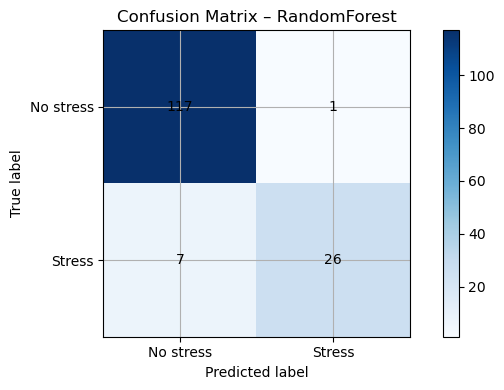

In [7]:
best_name = max(results, key=lambda k: results[k]["f1"])
print("Best model by F1-score:", best_name)

best_model = models[best_name]
if best_name == "RandomForest":
    y_pred_best = best_model.predict(X_test)
else:
    y_pred_best = best_model.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred_best)
print("Confusion matrix:\n", cm)

fig, ax = plt.subplots()
im = ax.imshow(cm, cmap="Blues")
ax.set_title(f"Confusion Matrix – {best_name}")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["No stress", "Stress"])
ax.set_yticklabels(["No stress", "Stress"])

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()


## 6. Unsupervised Learning for Feature Engineering (PCA)

We apply PCA to the scaled features to keep 95% of the variance, and retrain a Logistic Regression model on the PCA-transformed features.

In [8]:
pca = PCA(n_components=0.95, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Original feature dimension:", X_train_scaled.shape[1])
print("PCA-reduced dimension:", X_train_pca.shape[1])

log_pca = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
log_pca.fit(X_train_pca, y_train)
y_pred_pca = log_pca.predict(X_test_pca)

acc_pca = accuracy_score(y_test, y_pred_pca)
prec_pca = precision_score(y_test, y_pred_pca)
rec_pca = recall_score(y_test, y_pred_pca)
f1_pca = f1_score(y_test, y_pred_pca)

results["LogisticRegression_PCA"] = {
    "accuracy": acc_pca,
    "precision": prec_pca,
    "recall": rec_pca,
    "f1": f1_pca
}

print("\nLogistic Regression on PCA features")
print(f"Accuracy : {acc_pca:.3f}")
print(f"Precision: {prec_pca:.3f}")
print(f"Recall   : {rec_pca:.3f}")
print(f"F1-score : {f1_pca:.3f}")


Original feature dimension: 30
PCA-reduced dimension: 11

Logistic Regression on PCA features
Accuracy : 0.841
Precision: 0.667
Recall   : 0.545
F1-score : 0.600


## 7. Hyperparameter Tuning (Random Forest)

We perform GridSearchCV on the Random Forest to find better hyperparameters and compare performance with the baseline RF.

In [9]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5]
}

rf_base = RandomForestClassifier(random_state=RANDOM_STATE)

grid_search = GridSearchCV(
    rf_base,
    param_grid,
    cv=3,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best RF parameters:", grid_search.best_params_)
print("Best cross-validated F1:", grid_search.best_score_)

rf_tuned = grid_search.best_estimator_
y_pred_tuned = rf_tuned.predict(X_test)

acc_tuned = accuracy_score(y_test, y_pred_tuned)
prec_tuned = precision_score(y_test, y_pred_tuned)
rec_tuned = recall_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)

results["RandomForest_Tuned"] = {
    "accuracy": acc_tuned,
    "precision": prec_tuned,
    "recall": rec_tuned,
    "f1": f1_tuned
}

print("\nTuned Random Forest on test set")
print(f"Accuracy : {acc_tuned:.3f}")
print(f"Precision: {prec_tuned:.3f}")
print(f"Recall   : {rec_tuned:.3f}")
print(f"F1-score : {f1_tuned:.3f}")


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best RF parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validated F1: 0.8387793830831806

Tuned Random Forest on test set
Accuracy : 0.934
Precision: 0.926
Recall   : 0.758
F1-score : 0.833


## 8. Model Comparison and Visualisation

We compare all models using accuracy, precision, recall and F1-score.

                        accuracy  precision    recall        f1
LogisticRegression      0.874172   0.750000  0.636364  0.688525
RandomForest            0.947020   0.962963  0.787879  0.866667
MLP                     0.940397   0.900000  0.818182  0.857143
LogisticRegression_PCA  0.841060   0.666667  0.545455  0.600000
RandomForest_Tuned      0.933775   0.925926  0.757576  0.833333


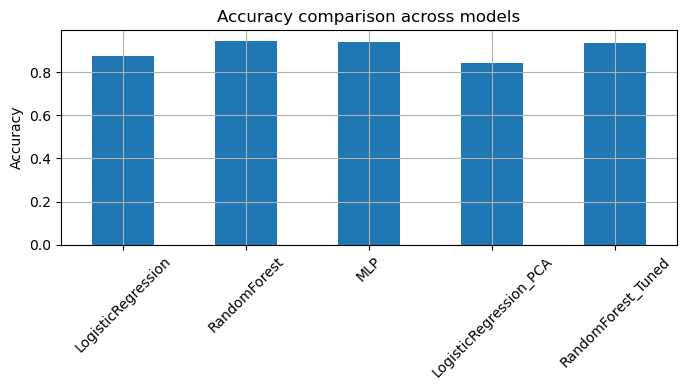

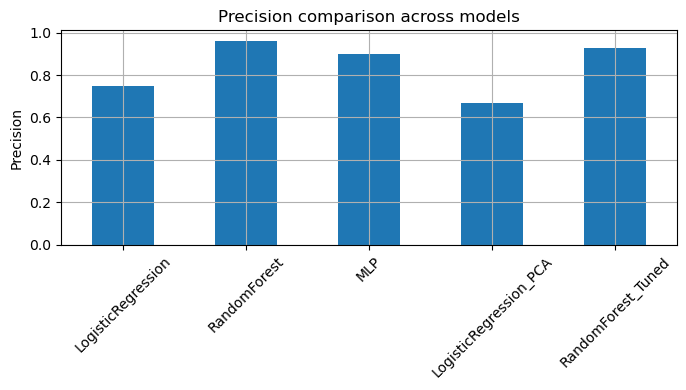

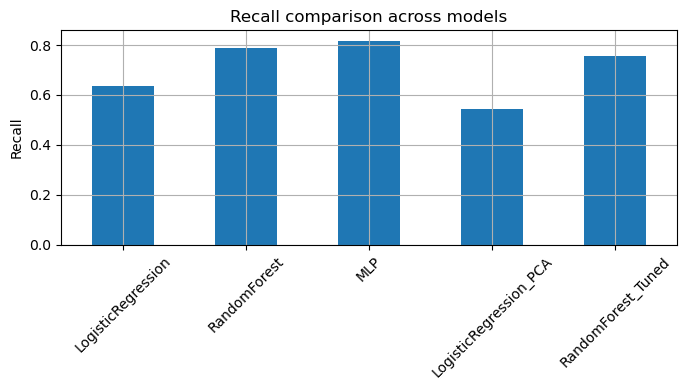

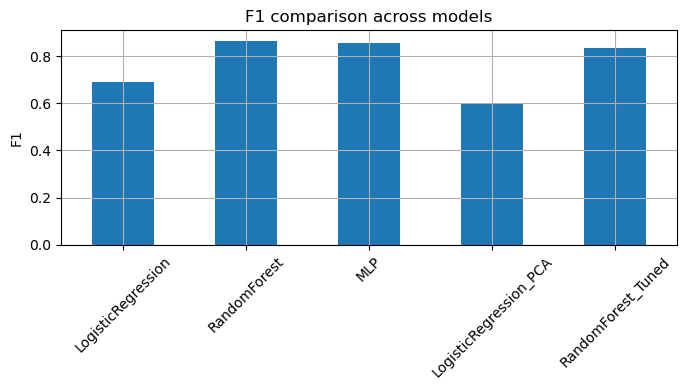

In [10]:
results_df = pd.DataFrame(results).T
print(results_df)

metrics = ["accuracy", "precision", "recall", "f1"]

for metric in metrics:
    ax = results_df[metric].plot(kind="bar", rot=45)
    ax.set_ylabel(metric.capitalize())
    ax.set_title(f"{metric.capitalize()} comparison across models")
    plt.tight_layout()
    plt.show()


## 9. Feature Importance (Random Forest)

We inspect the top important features according to the baseline Random Forest.

eda_std        0.104088
bvp_median     0.066599
eda_max        0.050135
eda_median     0.047229
eda_min        0.046962
eda_mean       0.045275
acc_y_max      0.044819
acc_z_min      0.040909
temp_max       0.038461
acc_y_mean     0.034816
temp_min       0.032797
temp_mean      0.032276
acc_x_min      0.032102
temp_median    0.031578
acc_z_mean     0.030712
dtype: float64


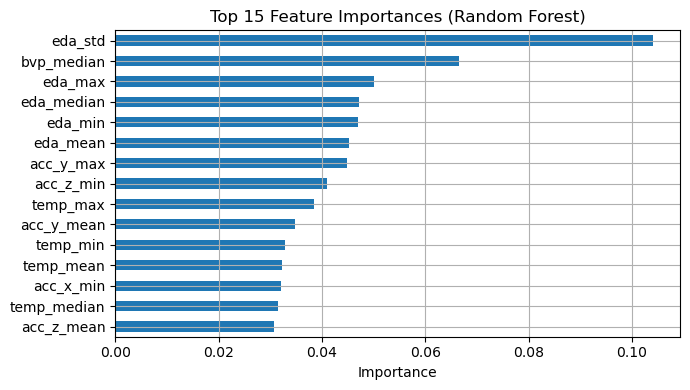

In [11]:
rf_model = models["RandomForest"]
importances = rf_model.feature_importances_

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print(feat_imp.head(15))

top_k = 15
ax = feat_imp.head(top_k).sort_values().plot(kind="barh")
ax.set_xlabel("Importance")
ax.set_title("Top 15 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


## 10. Exporting Datasets and Metrics

We export the feature dataset and the model performance metrics as CSV files for use in the written report.

In [12]:
df.to_csv("wesad_features.csv", index=False)
results_df.to_csv("wesad_model_metrics.csv")

print("Saved: wesad_features.csv")
print("Saved: wesad_model_metrics.csv")


Saved: wesad_features.csv
Saved: wesad_model_metrics.csv


## 11. (Optional) Deep Learning on Raw Time-Series (1D CNN)

If TensorFlow is available, this section demonstrates a simple 1D CNN trained on raw windows of BVP, EDA, TEMP and ACC signals.

Processing sequences for S10: C:\Users\dell\Desktop\ML\WESAD\S10\S10.pkl
S10: 52 windows (seq)
Processing sequences for S11: C:\Users\dell\Desktop\ML\WESAD\S11\S11.pkl
S11: 52 windows (seq)
Processing sequences for S13: C:\Users\dell\Desktop\ML\WESAD\S13\S13.pkl
S13: 52 windows (seq)
Processing sequences for S14: C:\Users\dell\Desktop\ML\WESAD\S14\S14.pkl
S14: 51 windows (seq)
Processing sequences for S15: C:\Users\dell\Desktop\ML\WESAD\S15\S15.pkl
S15: 50 windows (seq)
Processing sequences for S16: C:\Users\dell\Desktop\ML\WESAD\S16\S16.pkl
S16: 49 windows (seq)
Processing sequences for S17: C:\Users\dell\Desktop\ML\WESAD\S17\S17.pkl
S17: 50 windows (seq)
Processing sequences for S2: C:\Users\dell\Desktop\ML\WESAD\S2\S2.pkl
S2: 48 windows (seq)
Processing sequences for S3: C:\Users\dell\Desktop\ML\WESAD\S3\S3.pkl
S3: 50 windows (seq)
Processing sequences for S4: C:\Users\dell\Desktop\ML\WESAD\S4\S4.pkl
S4: 50 windows (seq)
Processing sequences for S5: C:\Users\dell\Desktop\ML\WESAD\S5

c:\Users\dell\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6460 - loss: 13.5336 - val_accuracy: 0.7769 - val_loss: 3.0011
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6025 - loss: 2.2088 - val_accuracy: 0.7273 - val_loss: 0.5986
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7578 - loss: 0.7868 - val_accuracy: 0.8099 - val_loss: 0.5488
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7805 - loss: 0.5601 - val_accuracy: 0.8099 - val_loss: 0.4411
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7867 - loss: 0.4071 - val_accuracy: 0.7686 - val_loss: 0.4562
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8302 - loss: 0.3918 - val_accuracy: 0.7934 - val_loss: 0.4711
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8302 - loss: 0.3709 - val_accuracy: 0.8182 - val_loss: 0.4401
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8613 - loss: 0.3655 - val_accuracy: 0.8347 - val_loss: 0.4070

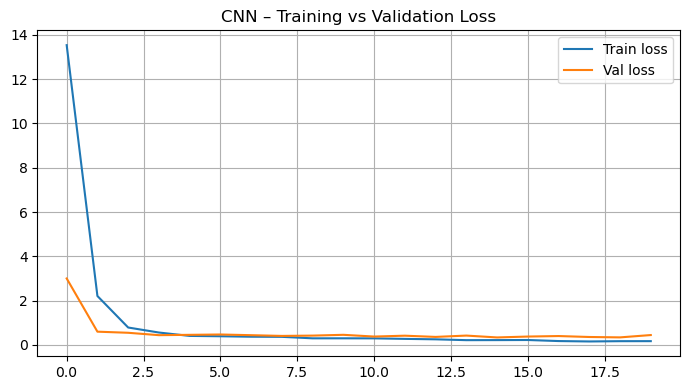

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1D CNN performance on raw sequences:
Accuracy : 0.848
Precision: 0.727
Recall   : 0.485
F1-score : 0.582


In [13]:
if not TF_AVAILABLE:
    print("TensorFlow is not available in this environment. Skipping deep learning section.")
else:
    def process_subject_sequences(subject_folder: str, fs_target: int = 4, window_sec: int = 60):
        pkl_path = os.path.join(DATA_DIR, subject_folder, subject_folder + ".pkl")
        print(f"Processing sequences for {subject_folder}: {pkl_path}")

        with open(pkl_path, "rb") as f:
            data = pickle.load(f, encoding="latin1")

        wrist = data["signal"]["wrist"]
        labels_raw = data["label"].ravel()

        # Downsample
        bvp  = wrist["BVP"][::16]
        eda  = wrist["EDA"]
        temp = wrist["TEMP"]
        acc  = wrist["ACC"][::8, :]
        labels_ds = labels_raw[::175]

        # Align lengths
        L = min(len(bvp), len(eda), len(temp), len(acc), len(labels_ds))
        bvp, eda, temp, acc, labels_ds = (
            bvp[:L], eda[:L], temp[:L], acc[:L], labels_ds[:L]
        )

        fs = fs_target
        W = fs * window_sec  # 240

        X_seq, y_seq = [], []

        def fix_shape(x, length):
            """Convert x to shape (length,), trimming or padding as needed."""
            x = np.asarray(x).reshape(-1)         # flatten ANY shape to 1D

            if len(x) > length:
                return x[:length]                 # trim
            elif len(x) < length:
                return np.pad(x, (0, length-len(x)), mode="edge")  # pad
            return x                              # exact length

        for start in range(0, L - W, W):
            end = start + W

            # Determine label
            window_labels = labels_ds[start:end]
            lab_raw, _ = Counter(window_labels).most_common(1)[0]
            lab = map_label(lab_raw)
            if lab is None:
                continue

            # Extract channels
            wbvp  = fix_shape(bvp[start:end], W)
            weda  = fix_shape(eda[start:end], W)
            wtemp = fix_shape(temp[start:end], W)

            wacc  = acc[start:end]
            if wacc.shape[0] == 0:
                continue
            
            acc_x = fix_shape(wacc[:,0], W)
            acc_y = fix_shape(wacc[:,1], W)
            acc_z = fix_shape(wacc[:,2], W)

            # Now everything is shape (240,)
            # Guaranteed identical — stacking will NEVER fail
            window = np.stack([wbvp, weda, wtemp, acc_x, acc_y, acc_z], axis=-1)

            X_seq.append(window)
            y_seq.append(lab)

        return np.array(X_seq), np.array(y_seq)


    X_seq_list = []
    y_seq_list = []

    for subj in subjects:
        Xs, ys = process_subject_sequences(subj)
        if len(Xs) == 0:
            print(f"No valid windows for {subj}, skipping.")
            continue
        print(f"{subj}: {Xs.shape[0]} windows (seq)")
        X_seq_list.append(Xs)
        y_seq_list.append(ys)

    if len(X_seq_list) == 0:
        print("No sequence data extracted. Skipping CNN model.")
    else:
        X_seq = np.vstack(X_seq_list)
        y_seq = np.hstack(y_seq_list)

        print("Sequence dataset shape:", X_seq.shape)
        print("Sequence label distribution:", Counter(y_seq))

        X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
            X_seq, y_seq, test_size=0.2, random_state=RANDOM_STATE, stratify=y_seq
        )

        time_steps = X_train_seq.shape[1]
        n_channels = X_train_seq.shape[2]

        model = Sequential([
            InputLayer(input_shape=(time_steps, n_channels)),
            Conv1D(32, kernel_size=5, activation="relu"),
            MaxPooling1D(pool_size=2),
            Conv1D(64, kernel_size=5, activation="relu"),
            MaxPooling1D(pool_size=2),
            Flatten(),
            Dense(64, activation="relu"),
            Dropout(0.5),
            Dense(1, activation="sigmoid")
        ])

        model.compile(
            optimizer="adam",
            loss="binary_crossentropy",
            metrics=["accuracy"]
        )

        es = EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True
        )

        history = model.fit(
            X_train_seq, y_train_seq,
            validation_split=0.2,
            epochs=30,
            batch_size=64,
            callbacks=[es],
            verbose=1
        )

        plt.figure()
        plt.plot(history.history["loss"], label="Train loss")
        plt.plot(history.history["val_loss"], label="Val loss")
        plt.legend()
        plt.title("CNN – Training vs Validation Loss")
        plt.tight_layout()
        plt.show()

        y_prob = model.predict(X_test_seq).ravel()
        y_pred_seq = (y_prob >= 0.5).astype(int)

        acc_dl = accuracy_score(y_test_seq, y_pred_seq)
        prec_dl = precision_score(y_test_seq, y_pred_seq)
        rec_dl = recall_score(y_test_seq, y_pred_seq)
        f1_dl = f1_score(y_test_seq, y_pred_seq)

        print("1D CNN performance on raw sequences:")
        print(f"Accuracy : {acc_dl:.3f}")
        print(f"Precision: {prec_dl:.3f}")
        print(f"Recall   : {rec_dl:.3f}")
        print(f"F1-score : {f1_dl:.3f}")
